# Auto Insurance Analysis

## Exploratory Data Analysis

## Project Goals

- Analyze auto insurance data.
- Build a logistic regression model to predict crash probability for auto insurance customers.
- Build a linear regression model to predict crash cost for auto insurance customers.
- Use model results to develop crash percentage, assign customers to new risk profiles, and risk probability percentages.
- Determine cost of premiums based on customer risk profiles and risk probability percentages.

## Summary of Data

The dataset for this project contains 6044 records of auto insurance data. Each record
represents a customer at an auto insurance company. Using this data, we will be able to ascertain what
influences the likelihood of a car crash. Then subsequently, we will be able to determine the cost to resolve a claim. The data in this project is the typical type of corporate data you would receive from a company in the insurance field-- a typical flat file from client records.

### Library Import

In [1]:
#Import libraries
%run ../python_files/imports

## Data Import and Data Examination

In [2]:
# import auto insurance data
auto_df = pd.read_csv('../data/auto_insurance_data.csv')

# change column names to lower-case
auto_df.columns = [i.lower() for i in auto_df.columns]

# quick overview of the dataset
auto_df

,crash,crash_cost,kidsdriv,age,homekids,yoj,income,parent1,home_val,mstatus,sex,education,job,travtime,car_use,bluebook,tif,car_type,red_car,oldclaim,clm_freq,revoked,mvr_pts,car_age,urbanicity
0,0,0.0,0,60,0,11,67349.381620,No,0.0000,No,M,PhD,Professional,13.950586,Private,14230,11,Minivan,yes,4461,2,No,3,18,Highly Urban/ Urban
1,0,0.0,0,43,0,11,91449.254640,No,257251.6354,No,M,High School,Blue Collar,21.943209,Commercial,14940,1,Minivan,yes,0,0,No,0,1,Highly Urban/ Urban
2,0,0.0,0,35,1,10,16038.587100,No,124190.7529,Yes,F,High School,Clerical,5.000000,Private,4010,4,SUV,no,38690,2,No,3,10,Highly Urban/ Urban
3,1,2946.0,0,34,1,12,125301.242500,Yes,0.0000,No,F,Bachelors,Blue Collar,45.703013,Commercial,17430,1,Sports Car,no,0,0,No,0,7,Highly Urban/ Urban
4,1,2501.0,0,34,0,10,62977.824160,No,0.0000,No,F,Bachelors,Clerical,33.639949,Private,11200,1,SUV,no,0,0,No,0,1,Highly Urban/ Urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6039,0,0.0,0,41,0,7,6255.902602,No,0.0000,No,M,High School,Student,40.664049,Private,5600,1,Pickup,no,0,0,No,0,7,Highly Rural
6040,0,0.0,0,35,0,11,43111.840100,No,0.0000,No,M,High School,Blue Collar,50.996441,Commercial,27330,10,Panel Truck,yes,0,0,No,0,8,Highly Rural
6041,0,0.0,1,45,2,9,164668.837000,No,386273.4090,Yes,M,PhD,Manager,21.267951,Private,13270,15,Minivan,no,0,0,No,2,17,Highly Urban/ Urban
6042,0,0.0,0,50,0,7,43445.497870,No,149247.7801,Yes,F,Bachelors,Home Maker,36.170517,Private,22550,6,Minivan,no,0,0,No,0,11,Highly Urban/ Urban


After a quick overview of the dataset, we see that we are working with 6044 total observations and 25 different variables. The response variable we will be using is 'crash', which indicates whether a car was in a crash or not. The remaining 24 variables will be used as explanatory variables. We also notice a good mix of continuous and categorical variables.

In [3]:
# quick review of the variables in the dataset
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6044 entries, 0 to 6043
Data columns (total 25 columns):
crash         6044 non-null int64
crash_cost    6044 non-null float64
kidsdriv      6044 non-null int64
age           6044 non-null int64
homekids      6044 non-null int64
yoj           6044 non-null int64
income        6044 non-null float64
parent1       6044 non-null object
home_val      6044 non-null float64
mstatus       6044 non-null object
sex           6044 non-null object
education     6044 non-null object
job           6044 non-null object
travtime      6044 non-null float64
car_use       6044 non-null object
bluebook      6044 non-null int64
tif           6044 non-null int64
car_type      6044 non-null object
red_car       6044 non-null object
oldclaim      6044 non-null int64
clm_freq      6044 non-null int64
revoked       6044 non-null object
mvr_pts       6044 non-null int64
car_age       6044 non-null int64
urbanicity    6044 non-null object
dtypes: float64(4), int64

For modeling purposes, we know that we will have to convert all categorical variables to dummy variables. As we can see above, there are 10 categorical variables that will need to go through this conversion.

In [4]:
# quick review of the characteristics of our current continuous variables in the dataset
auto_df.describe()

,crash,crash_cost,kidsdriv,age,homekids,yoj,income,home_val,travtime,bluebook,tif,oldclaim,clm_freq,mvr_pts,car_age
count,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000
mean,0.264891,1479.664479,0.173230,44.628061,0.743547,10.494375,58178.583187,150091.831763,33.695527,15235.584050,5.360523,3999.992058,0.783752,1.699868,7.922733
std,0.441312,4553.548768,0.515462,8.708472,1.132793,4.138805,43830.436426,123736.396505,15.889558,8041.627756,4.144970,8815.064402,1.153627,2.158059,5.582574
min,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1500.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,39.000000,0.000000,9.000000,26745.589935,0.000000,22.800199,9170.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,45.000000,0.000000,11.000000,51624.202055,159147.432550,33.016349,14080.000000,4.000000,0.000000,0.000000,1.000000,8.000000
75%,1.000000,1036.250000,0.000000,51.000000,1.000000,13.000000,81289.165560,233060.839575,43.945989,20120.000000,7.000000,4540.000000,2.000000,3.000000,12.000000
max,1.000000,85523.653350,4.000000,81.000000,5.000000,23.000000,367030.262000,885282.345000,142.120630,65970.000000,25.000000,57037.000000,5.000000,13.000000,28.000000


We notice above that there is a large range between some of our observations. However, it is not appropriate to dismiss these as outliers, as we do not want to skew or create bias within our dataset. Also, above we cannot view the descriptions of our 10 categorical variables until we convert them to continous variables.

In [5]:
# check the number of NaN values in the dataset
auto_df.isna().sum()

crash         0
crash_cost    0
kidsdriv      0
age           0
homekids      0
yoj           0
income        0
parent1       0
home_val      0
mstatus       0
sex           0
education     0
job           0
travtime      0
car_use       0
bluebook      0
tif           0
car_type      0
red_car       0
oldclaim      0
clm_freq      0
revoked       0
mvr_pts       0
car_age       0
urbanicity    0
dtype: int64

Fortunately, we see above that our dataset does not contain any missing values, so we will not need to worry about imputation.

## Data Cleaning, Data Transformations, and Data Exploration

Below, we created dummy variables for our 10 categorical variables: mstatus, sex, parent1, red_car, revoked, urbanicity, education, job, car_use, and car_type. Using the mapping technique, these changes were appended to the dataset, and therefore, we did not have to drop any variables.

In [6]:
# Create dummy values for the categorical variables

auto_df['mstatus'] = auto_df['mstatus'].map({'Yes': 1, 'No': 0})
auto_df['sex'] = auto_df['sex'].map({'M': 1, 'F': 0})
auto_df['parent1'] = auto_df['parent1'].map({'Yes': 1, 'No': 0})
auto_df['red_car'] = auto_df['red_car'].map({'yes': 1, 'no': 0})
auto_df['revoked'] = auto_df['revoked'].map({'Yes': 1, 'No': 0})
auto_df['urbanicity'] = auto_df['urbanicity'].map({'Highly Urban/ Urban': 1, 'Highly Rural': 0})
auto_df['education'] = auto_df['education'].map({'<High School': 0, 'High School': 0, 'Bachelors': 1, 'Masters': 1, 'PhD': 1})
auto_df['job'] = auto_df['job'].map({'Student': 1, 'Blue Collar': 0, 'Clerical': 0, 'Doctor': 0, 'Home Maker': 0, 'Lawyer': 0, 'Manager': 0, 'Professional': 0})
auto_df['car_use'] = auto_df['car_use'].map({'Commercial': 1, 'Private': 0})
auto_df['car_type'] = auto_df['car_type'].map({'Sports Car': 1, 'SUV': 1, 'Minivan': 1, 'Pickup': 0, 'Van': 0, 'Panel Truck': 0})

Next, we created log-transformed variables for our continuous variables that did not have normal distributions. Then, we dropped the original variables (the pre-transformed variables) from out dataset. This was performed on 3 of our feature variables: tif, bluebook, and travtime.

In [7]:
# Log Transformations for non-normalized variables. Then, drop the original variable from the dataset.

def log_col(df, col):
    '''Convert column to log values and
    drop the original column
    '''
    df[f'{col}_log'] = np.log(df[col])
    df.drop(col, axis=1, inplace=True)

log_col(auto_df, 'tif')
log_col(auto_df, 'bluebook')
log_col(auto_df, 'travtime')

In [8]:
# quick review of the characteristics of all variables in the dataset, 
# including the new dummy variables and log-transformed variables
auto_df.describe()

,crash,crash_cost,kidsdriv,age,homekids,yoj,income,parent1,home_val,mstatus,sex,education,job,car_use,car_type,red_car,oldclaim,clm_freq,revoked,mvr_pts,car_age,urbanicity,tif_log,bluebook_log,travtime_log
count,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000,6044.000000
mean,0.264891,1479.664479,0.173230,44.628061,0.743547,10.494375,58178.583187,0.136003,150091.831763,0.595136,0.444408,0.532263,0.088848,0.337525,0.694242,0.279782,3999.992058,0.783752,0.123263,1.699868,7.922733,0.784911,1.300029,9.468329,3.373269
std,0.441312,4553.548768,0.515462,8.708472,1.132793,4.138805,43830.436426,0.342820,123736.396505,0.490906,0.496941,0.498999,0.284548,0.472905,0.460766,0.448929,8815.064402,1.153627,0.328766,2.158059,5.582574,0.410918,0.949558,0.623253,0.597306
min,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.313220,1.609438
25%,0.000000,0.000000,0.000000,39.000000,0.000000,9.000000,26745.589935,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,9.123693,3.126769
50%,0.000000,0.000000,0.000000,45.000000,0.000000,11.000000,51624.202055,0.000000,159147.432550,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.000000,1.000000,1.386294,9.552511,3.497003
75%,1.000000,1036.250000,0.000000,51.000000,1.000000,13.000000,81289.165560,0.000000,233060.839575,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,4540.000000,2.000000,0.000000,3.000000,12.000000,1.000000,1.945910,9.909470,3.782961
max,1.000000,85523.653350,4.000000,81.000000,5.000000,23.000000,367030.262000,1.000000,885282.345000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,57037.000000,5.000000,1.000000,13.000000,28.000000,1.000000,3.218876,11.096955,4.956676


Our auto_df dataset is now ready for further evaluation. Above, we observe the newly edited variables from our dummy transformations and log-transformations. This leaves us with the same number of total observations and variable columns: 6044 observations and 25 variables (crash and crash_cost are our 2 response variables, and the remaining 23 variables are our feature variables).
<p>
Below, we explore the correlations between our response variables and feature variables. The correlation heatmap does a great job in providing a visual understanding of these relationships.

In [9]:
# Correlations between all variables in auto_df dataset
auto_df.corr(method = 'pearson')

,crash,crash_cost,kidsdriv,age,homekids,yoj,income,parent1,home_val,mstatus,sex,education,job,car_use,car_type,red_car,oldclaim,clm_freq,revoked,mvr_pts,car_age,urbanicity,tif_log,bluebook_log,travtime_log
crash,1.000000,0.541367,0.087047,-0.115377,0.112076,-0.066545,-0.148009,0.162166,-0.184700,-0.131237,-0.023766,-0.149655,0.076107,0.160663,-0.050034,-0.025000,0.137959,0.227597,0.142177,0.230315,-0.109774,0.226634,-0.081506,-0.118438,0.058799
crash_cost,0.541367,1.000000,0.039043,-0.056547,0.053782,-0.024286,-0.062691,0.095155,-0.097502,-0.093226,0.002727,-0.069552,0.021087,0.104200,-0.043737,-0.003450,0.074673,0.113519,0.061299,0.140950,-0.069636,0.123815,-0.041611,-0.011687,0.026778
kidsdriv,0.087047,0.039043,1.000000,-0.066414,0.454151,0.051069,-0.031829,0.188794,-0.011693,0.045707,-0.040890,-0.063229,0.022537,0.009919,0.011934,-0.033561,0.022373,0.040744,0.038028,0.062961,-0.047219,-0.027189,-0.010593,-0.006510,-0.009934
age,-0.115377,-0.056547,-0.066414,1.000000,-0.445075,0.132239,0.183469,-0.316683,0.215825,0.098314,0.062597,0.205618,-0.126233,-0.073663,0.014585,0.017014,-0.026746,-0.030755,-0.035425,-0.078030,0.190402,0.043121,0.000960,0.154610,0.010974
homekids,0.112076,0.053782,0.454151,-0.445075,1.000000,0.095802,-0.145580,0.445637,-0.104216,0.048344,-0.109697,-0.182381,0.126659,0.027234,0.047897,-0.069421,0.033910,0.034546,0.044903,0.071197,-0.155141,-0.053463,-0.008041,-0.092115,-0.025897
yoj,-0.066545,-0.024286,0.051069,0.132239,0.095802,1.000000,0.298470,-0.046929,0.277267,0.141614,0.066386,0.075126,-0.333926,0.006804,-0.029104,0.040346,0.000563,-0.034480,-0.004659,-0.037373,0.053614,0.074113,0.031789,0.158698,-0.017399
income,-0.148009,-0.062691,-0.031829,0.183469,-0.145580,0.298470,1.000000,-0.064988,0.581752,-0.025009,0.057375,0.499047,-0.372559,-0.016405,-0.066309,0.031090,-0.040664,-0.061623,-0.016419,-0.077292,0.389804,0.201334,0.002586,0.342402,-0.033756
parent1,0.162166,0.095155,0.188794,-0.316683,0.445637,-0.046929,-0.064988,1.000000,-0.260003,-0.481028,-0.069260,-0.063381,0.052531,0.017918,0.031777,-0.044064,0.035195,0.058477,0.046511,0.077998,-0.058580,-0.007279,-0.014761,-0.054502,-0.018573
home_val,-0.184700,-0.097502,-0.011693,0.215825,-0.104216,0.277267,0.581752,-0.260003,1.000000,0.462835,0.038646,0.297892,-0.341076,-0.024875,-0.036522,0.000051,-0.061099,-0.103222,-0.046120,-0.099488,0.204926,0.106042,-0.004244,0.221549,-0.025692
mstatus,-0.131237,-0.093226,0.045707,0.098314,0.048344,0.141614,-0.025009,-0.481028,0.462835,1.000000,-0.006468,-0.037527,0.009966,-0.007896,0.004251,-0.018302,-0.042595,-0.076603,-0.037297,-0.060048,-0.029713,-0.006008,-0.003455,0.013444,0.006702


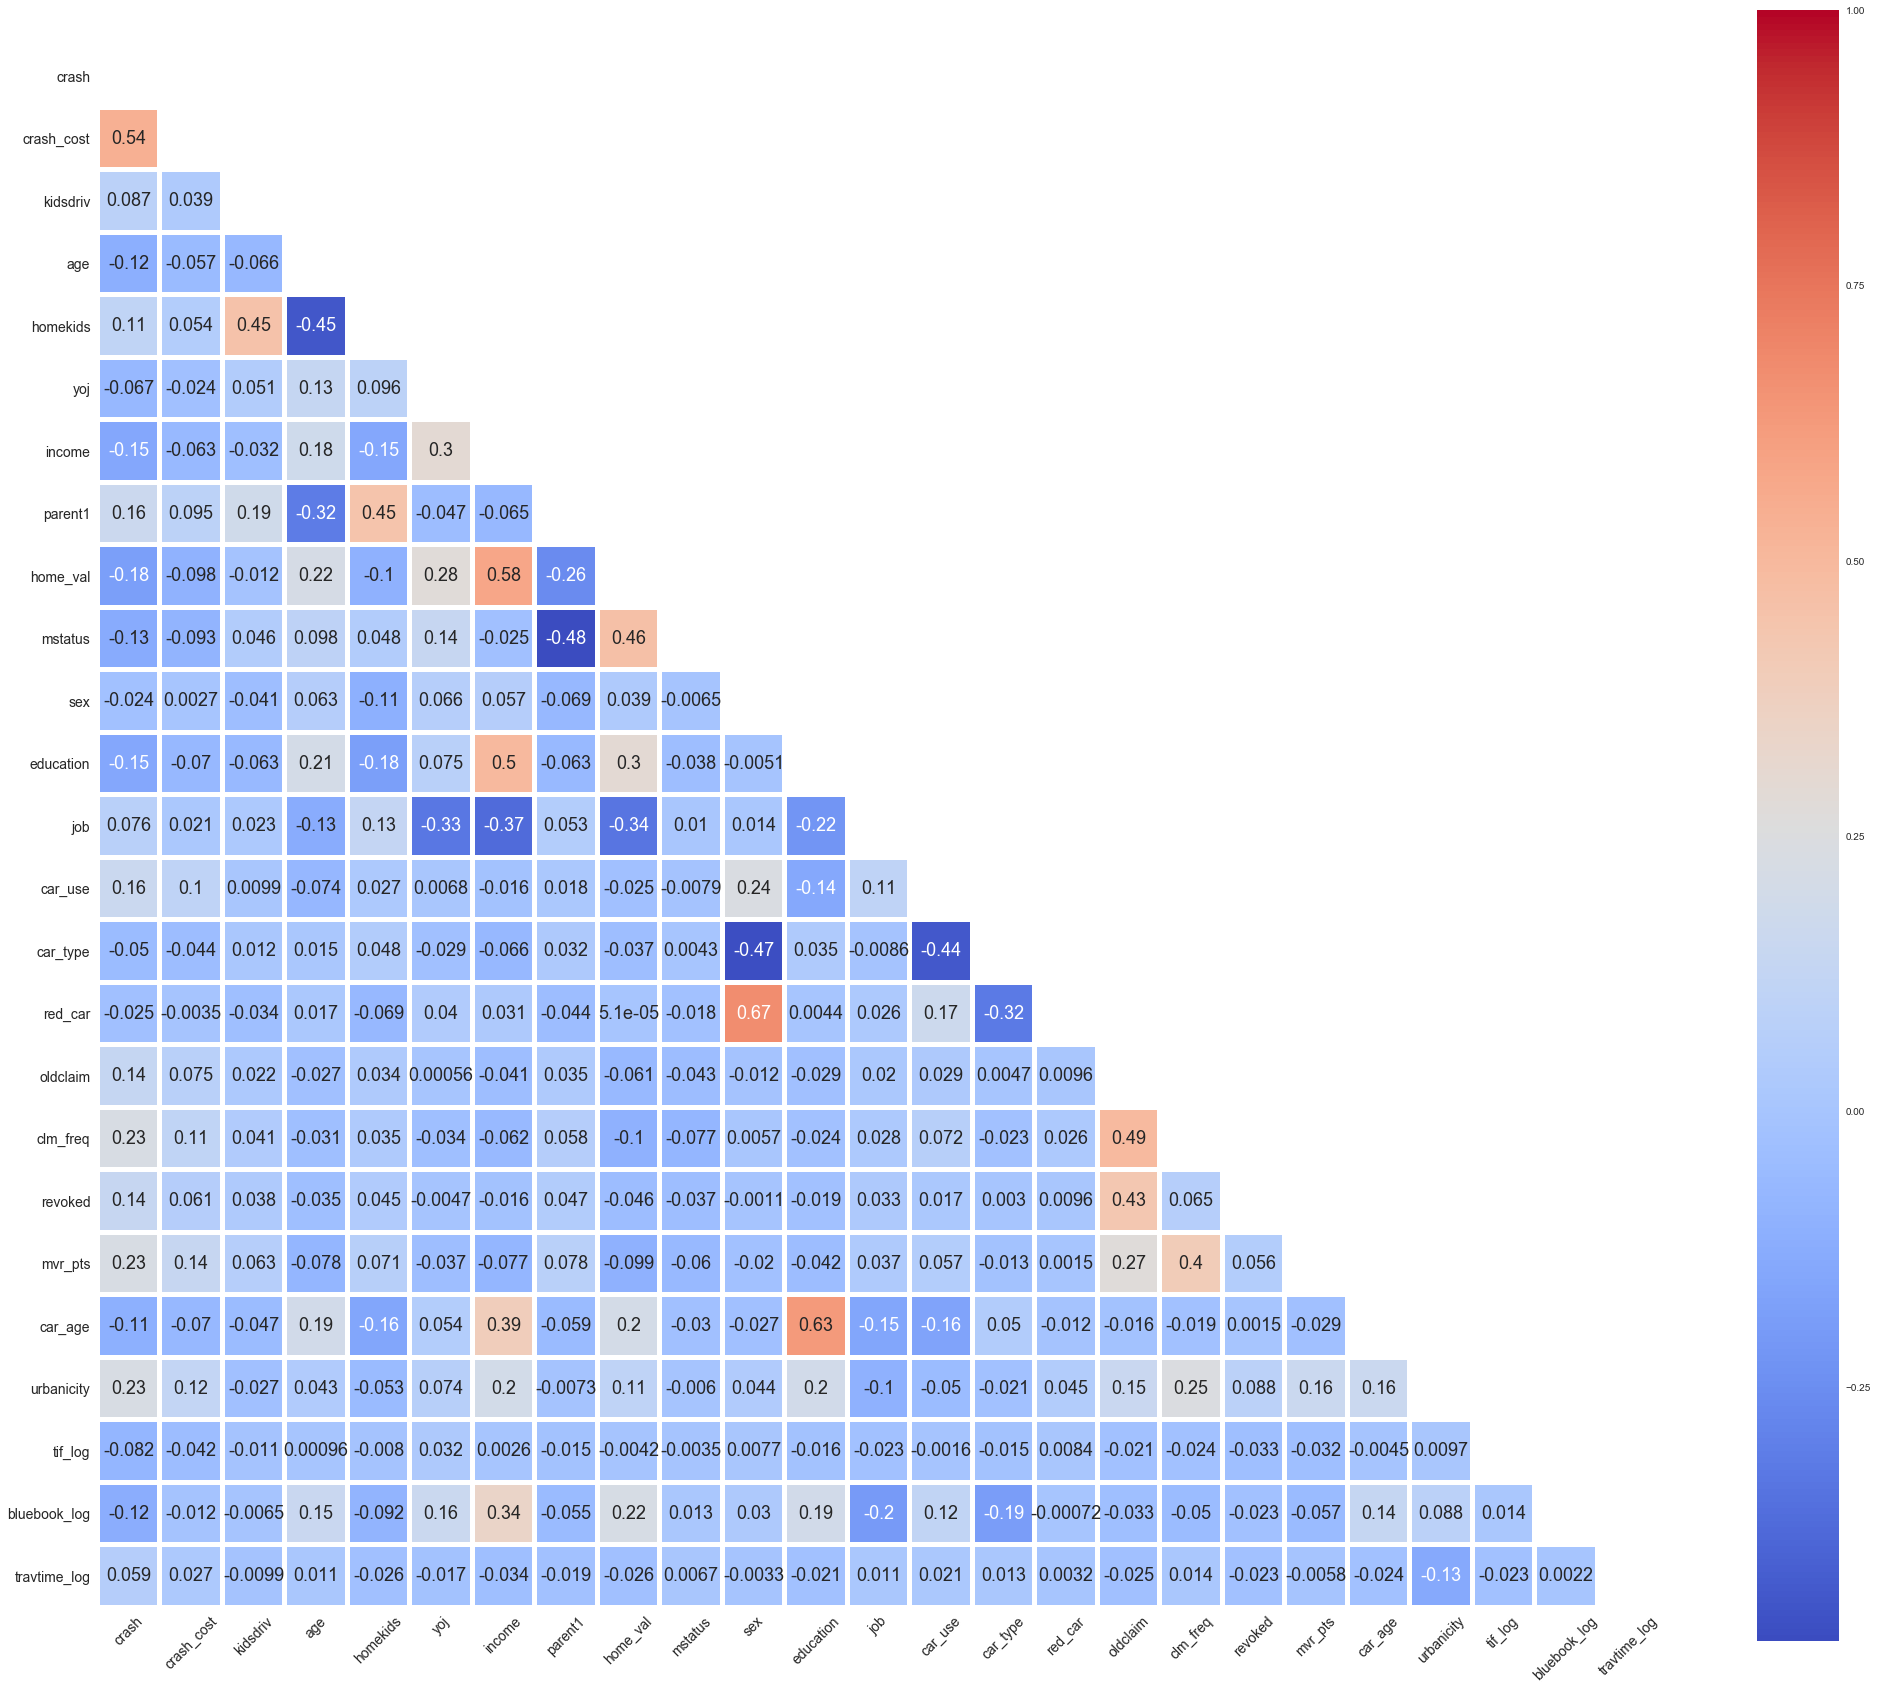

In [10]:
#Correlation Heatmap of all variables in auto_df dataset

mask = np.zeros_like(auto_df.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True

plt.figure(figsize=(35,30))
ax = sns.heatmap(auto_df.corr(method='pearson'), cmap="coolwarm", mask=mask, annot=True, annot_kws={"size": 18}, square=True, linewidths=4)
sns.set_style('white')
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14, rotation=0)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

## Initial Train and Test Dataset Creation

In this section, we split the auto_df dataset into training and test datasets for modeling purposes, both for our logistic regression model and our simple linear regression model. We used an 80%-20% training and test split, and randomized the selection of the data pulled from the original dataset.

For our linear regression model, we did have to alter which data we were using because of our response variable crash_cost. Since crash_cost only gives us crash amounts for customers who DID get in accidents this past year, we must filter out the customers who did NOT get into car accidents this year. We can use this model to predict crash amounts for those who did get in a crash and might get into another accident. For the customers who have not been involved in an accident, we are not suggesting that it is impossible for them to get into a future accident. For those customers specifically, if they do get into a future accident, we can plug in their associated crash cost into our already established crash_cost model and then use that data to predict their future accident costs based on our feature variables. Since we do not have an associated crash_cost for these specific customers yet though, we cannot use them inside of this specific model. We can only add them to our model once they do in fact get into a crash (hopefully they don't!).

In [11]:
#Split auto_insurance_df into train and test datasets for our logistic and linear regression models

#train and test datasets for logistic regression model
crash = auto_df['crash']
features_log = auto_df.drop(['crash', 'crash_cost'], axis = 1)
x_train_log, x_test_log, y_train_log, y_test_log = train_test_split(features_log, crash, test_size = 0.2, random_state = 10)

#for our simple linear regression model, filter out customers who did NOT get into an accident this year, and create
# new dataframe consisting of only customers who DID get into an accident this year
customers_no_crash = auto_df[auto_df['crash'] == 0 ].index
auto_df.drop(customers_no_crash, inplace=True)

#train and test datasets for simple linear regression model
crash_cost = auto_df['crash_cost']
features_lin = auto_df.drop(['crash', 'crash_cost'], axis = 1)
x_train_lin, x_test_lin, y_train_lin, y_test_lin = train_test_split(features_lin, crash_cost, test_size = 0.2, random_state = 10)

## Feature Selection

For modeling purposes, we used recursive feature elimination for both our logistic regression model and our simple linear regression model. This process uses cross-validation techniques, using accuracy as a metric, to eliminate variables that may hurt our model performance. Those variables get dropped from the dataset prior to modeling.

### Recursive Feature Elimination for Logistic Regression Model

In [12]:
logreg_model = LogisticRegression()
rfecv_log = RFECV(estimator=logreg_model, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv_log.fit(x_train_log, y_train_log)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='auto', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='lbfgs', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [13]:
feature_importance_log = list(zip(features_log, rfecv_log.support_))
new_features_log = []
for key,value in enumerate(feature_importance_log):
    if(value[1]) == True:
        new_features_log.append(value[0])
        
print(new_features_log)

['kidsdriv', 'parent1', 'mstatus', 'sex', 'education', 'job', 'car_use', 'car_type', 'red_car', 'clm_freq', 'revoked', 'mvr_pts', 'urbanicity', 'tif_log', 'bluebook_log', 'travtime_log']


### Recursive Feature Elimination for Simple Linear Regression Model

In [14]:
linreg_model = LinearRegression()
rfecv_lin = RFECV(estimator=linreg_model, step=1, min_features_to_select = 1, scoring='r2')
rfecv_lin.fit(x_train_lin, y_train_lin)

RFECV(cv=None,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='r2', step=1, verbose=0)

In [15]:
feature_importance_lin = list(zip(features_lin, rfecv_lin.support_))
new_features_lin = []
for key,value in enumerate(feature_importance_lin):
    if(value[1]) == True:
        new_features_lin.append(value[0])
        
print(new_features_lin)

['bluebook_log']


## Final Train and Test Datasets after Feature Selection

Here, we create our final training and test datasets that will be used for our modeling process. After reviewing the structure of each dataset for both of our models, we notice that our recursive feature elimination process removed 7 features for our logistic regression model data, giving us 16 features for this model. However, this process did not remove any features for our simple linear regression model data, leaving us with all 23 features for this model. Now, with our cleaned final datasets, we are ready to move onto the modeling phase of our study.

In [16]:
#final train and test datasets for logistic regression model
x_train_log = x_train_log[new_features_log]
x_test_log = x_test_log[new_features_log]

#final train and test datasets for simple linear regression model
x_train_lin = x_train_lin[new_features_lin]
x_test_lin = x_test_lin[new_features_lin]

In [17]:
print(x_train_log.shape)
print(x_test_log.shape)
print(x_train_lin.shape)
print(x_test_lin.shape)

(4835, 16)
(1209, 16)
(1280, 1)
(321, 1)
